#ChigiBot

In the last 11 years, the country of Italy has held three different elections, and both in 2013 and in 2018 no clear majority emerged from the ballots. As a consequence, seven different governments were formed and six different individuals were appointed as prime ministers for the first time. Their political affiliations encompassed all the political spectrum.

This project uses a corpus of political speeches from the *Camera dei Deputati* during the last three *Legislature* (XVII, XVIII and XIX) to determine to what extent the language and topics contained in the political speeches of the six alternating prime ministers overlap.

Part of this code has been deployed to an online app at http://chigibot.eu.pythonanywhere.com.



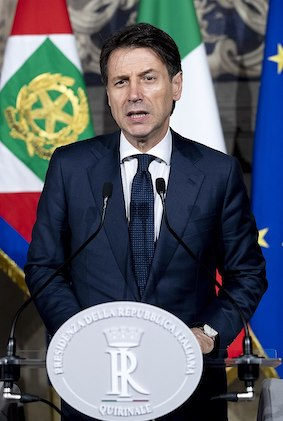

Giuseppe Conte was appointed as prime minister in May 2018 to lead a government coalition formed by Movimento 5 Stelle and Lega Nord (from *quirinale.it*).

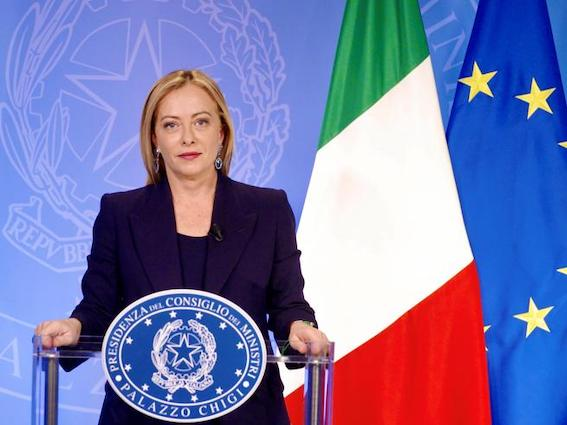

Giorgia Meloni is the first woman to serve as prime minister after her party Fratelli d'Italia won the 2022 elections (from *corriere.it*).

##1. Introduction

Load the Google Drive folder.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

##2. Data

The source data for the project has been mined from http://documenti.camera.it, and it contains political speeches delivered in the *Camera dei Deputati* between 2013 and 2024. Only speeches from the prime ministers are extracted, for a total of 24480 sentences.

The following code loads the source data and creates training and testing datasets.

In [ ]:
import os
import re
import numpy as np
from sklearn.model_selection import train_test_split

data_folder = 'data'

def extract_sentences(text):
    sentences = re.split(r'\.', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

sentences, labels = [], []

for class_folder in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_folder)
    if not os.path.isdir(class_path) or class_folder.startswith('.'):
        continue
    for doc_file in os.listdir(class_path):
        doc_path = os.path.join(class_path, doc_file)
        with open(doc_path, 'r', encoding='utf-8') as f:
            text = f.read()
            doc_sentences = extract_sentences(text)
            sentences.extend(doc_sentences)
            labels.extend([class_folder] * len(doc_sentences))

print('Number of Sentences:', len(sentences))
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, stratify=labels, random_state=1946)



Number of Sentences: 24480


##3. Train and Evaluate a NaiveBayes classifier

One of the simplest models for author attribution is a **NaiveBayes** classifier, which simply uses the word or word sequences (*n-grams*) distribution in a corpus to estimate the likelihood that each sentence belongs to each of a set of categories (in our case, politicians).

The following codes creates a NaiveBayes classifier using `scikit-learn`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

classifier = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=100000)),
    ('nb', MultinomialNB(alpha=0.01))
])

classifier.fit(X_train, y_train)


In [ ]:
y_pred = classifier.predict(X_test)
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
                         precision    recall  f1-score   support

         CONTE Giuseppe       0.80      0.87      0.84      1659
           DRAGHI Mario       0.70      0.59      0.64       533
GENTILONI SILVERI Paolo       0.70      0.54      0.61       277
           LETTA Enrico       0.71      0.50      0.58       484
         MELONI Giorgia       0.80      0.87      0.83      1379
           RENZI Matteo       0.73      0.75      0.74       564

               accuracy                           0.77      4896
              macro avg       0.74      0.69      0.71      4896
           weighted avg       0.77      0.77      0.77      4896



We can see from the results that while the precision/recall/f1 associated to Giuseppe Conte and Giorgia Meloni are above 0.80, the classifier struggles with the other categories, likely because the number of sentences in the training data is much lower.

These results can also be analyzed using a confusion matrix:

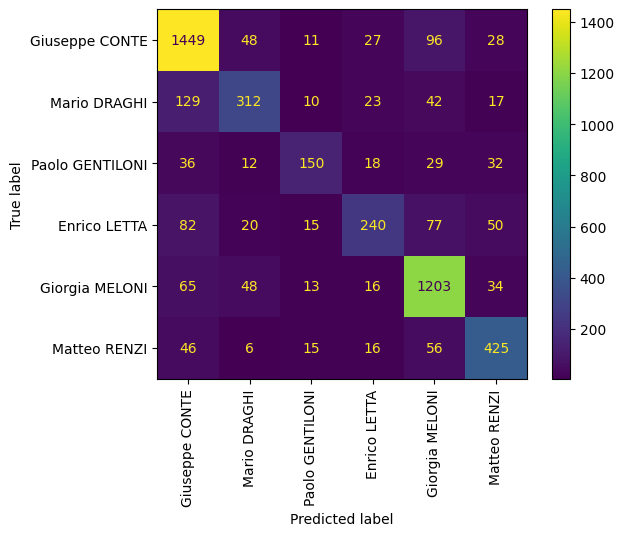

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels= ['Giuseppe CONTE', 'Mario DRAGHI', 'Paolo GENTILONI', 'Enrico LETTA', 'Giorgia MELONI',  'Matteo RENZI']

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', display_labels=labels)
plt.show()

Interestingly, several sentences by Mario Draghi were attributed to Giuseppe Conte, which can be explained by the fact that they were the prime ministers in charge during the Covid pandemic. The opposite does not hold: where the system wrongly attributed a sentence to Mario Draghi, the mistakes were equally distributed between Giuseppe Conte and Giorgia Meloni.



##4. From n-grams to BERT

NaiveBayes systems are quite easy to implement and straightforward to explain: all they do is calculate the probabilities that certain n-grams were sampled from a class using Bayes rule. But they do not understand the meaning of the sentences they process. This means that they are not good at distinguishing between positive and negative assertions and do not have any notion of synonymy.

To address these issues, we have to use more sophisticated models like **BERT**. BERT models are deep learning architectures based on [transformers](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)), and they are pre-trained on large corpora to create word embeddings that are sensitive to co-occurrence patterns rather than being static. This means that depending on their context, the models can have a better understanding of their meaning.  

The following code creates a classification model using the HuggingFace BERT model `bert-base-italian-xxl-cased` and the library `simpletransformers`.

#5. Fine-tune a BERT Language Model

We start by installing the `simpletransformers` library.

In [ ]:
# install simpletransformers
!pip install simpletransformers

Then we import a few modules that are necessary to train the model.

In [ ]:
from simpletransformers.classification import ClassificationModel
import torch

Since training a classifier leveraging a transformer-based model is computationally intensive, it is good practice to save the model parameters after the first round of training and re-using them in the future (to perform classification tasks or further fine-tune them).

In the following code we have commented out the line that downloads the pre-trained BERT model from Huggingface and added a line to load a local copy that we have already fine-tuned on the political speeches used here by processing the training data through the model for 5 epochs.

In [ ]:
cuda_available = torch.cuda.is_available()

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 5,
             "save_eval_checkpoints" : False,
             "save_model_every_epoch": False,
             "save_optimizer_and_scheduler" : False,
             "save_steps": False}

# Create a ClassificationModel
model = ClassificationModel(
    #"bert", "dbmdz/bert-base-italian-xxl-cased", # when the model is first trained, we must fetch it directly from HuggingFace
    "bert", "BERT/fine_tuned_bert-base-italian-xxl-cased_5", # when the model has been trained, we can fetch a local copy
    use_cuda=cuda_available,
    num_labels=6,
    args=train_args)

##6. Prepare training data

Training a BERT model using `simpletransformers` requires the training data to be formatted as a data frame and the labels to be expressed as integer numbers. We can use the `panda` library to do this.

In [ ]:
import pandas as pd

label_to_int = {'CONTE Giuseppe':0, 'DRAGHI Mario':1, 'GENTILONI SILVERI Paolo':2, 'LETTA Enrico':3, 'MELONI Giorgia':4,  'RENZI Matteo':5}
int_to_label = {value:key for key,value in label_to_int.items()}

train_df = pd.DataFrame([[X,label_to_int[y]] for X,y in zip(X_train,y_train)], columns=['text', 'label'])
test_df = pd.DataFrame([[X,label_to_int[y]] for X,y in zip(X_test,y_test)], columns=['text', 'label'])

print(train_df.shape)
print(test_df.shape)

(19584, 2)
(4896, 2)


##7. Fine-tune and save model (only the first time)

The model is trained (or better, fine-tuned, since it was already pre-trained) on the data and saved on the first run. Then, by calling a local fine-tuned version of the model at step 5) instead of the main model, we can  directly load the fine-tuned version.

The following code is then only activated on the very first training run. After that, since we can load the local copy of the trained parameters, it must be ignored.



In [ ]:
'''model.train_model(train_df)

model.model.save_pretrained('fine_tuned_bert-base-italian-xxl-cased_5')
model.tokenizer.save_pretrained('fine_tuned_bert-base-italian-xxl-cased_5')
model.config.save_pretrained('fine_tuned_bert-base-italian-xxl-cased_5')
'''

##8. Predict

Here we predict the labels associated with the test dataset.

In [ ]:
predictions, raw_outputs = model.predict(X_test)

##9. Evaluation

Finally, we can evaluate the model.

In [ ]:
print('\nClassification Report:')
print(classification_report(test_df['label'], predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1659
           1       0.71      0.75      0.73       533
           2       0.57      0.58      0.58       277
           3       0.59      0.56      0.57       484
           4       0.84      0.86      0.85      1379
           5       0.76      0.62      0.68       564

    accuracy                           0.78      4896
   macro avg       0.72      0.71      0.71      4896
weighted avg       0.78      0.78      0.78      4896



The model has a better balance between precision and recall, which marginally improves the overall f-score. This can also be seen from the confusion matrix.

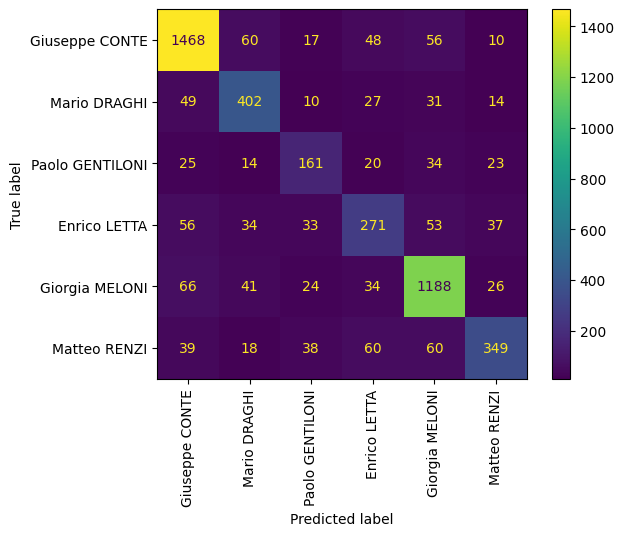

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_df['label'], predictions, xticks_rotation='vertical', display_labels=labels)
plt.show()

While the model is still making several mistakes, they are more distributed across categories, which means that the classifier is more robust to factors such as temporal/political/topical proximity.